<a href="https://colab.research.google.com/github/istruckman/llm-annotations-6s079/blob/master/6_s079_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
gdrive_dir = '/content/gdrive/'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import os
project_dir = os.path.join(gdrive_dir, "MyDrive/6.S079-project/")

In [ ]:
import pandas as pd

dataset_names = ['BC2GM', 'BC5CDR-chem', 'BC5CDR-disease', 'JNLPBA', 'NCBI-disease']
data = []
for name in dataset_names:
  url = project_dir+'/datasets/'+name+'/train_dev.tsv'
  df = pd.read_csv(url, delimiter='\t', header=None, engine='python', on_bad_lines='skip')
  df.columns = ['Token', 'Label']
  data.append(df)

In [ ]:
print(data)

[                      Token Label
0       Immunohistochemical     O
1                  staining     O
2                       was     O
3                  positive     O
4                       for     O
...                     ...   ...
237994                avian     I
237995            integrins     I
237996                  was     O
237997             obtained     O
237998                    .     O

[237999 rows x 2 columns],              Token Label
0       Selegiline     B
1                -     O
2          induced     O
3         postural     O
4      hypotension     O
...            ...   ...
94813   structural     O
94814          and     O
94815   functional     O
94816   impairment     O
94817            .     O

[94818 rows x 2 columns],              Token Label
0       Selegiline     O
1                -     O
2          induced     O
3         postural     B
4      hypotension     I
...            ...   ...
94813   structural     I
94814          and     I
94815   fun

In [ ]:
def tag_positions(group):
    length = len(group)
    if length > 1 and length < 5:
        return ['Beginning'] + ['Middle'] * (length - 2) + ['End', 'Period']
    elif length >= 5:
        return ['Beginning'] * 2 + ['Middle'] * (length - 4) + ['End'] * 2 + ['Period']
    elif length == 1:
        return ['Single', 'Period']
    return ['Period']

capital_letters = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

for df in data:
    positions = []
    current_sentence = []
    for i, row in df.iterrows():
        if row['Token'] == '.':
            # check if end of sentence:
            if i == len(df.iterrows()) - 1 or df.iterrows()[i + 1][0] in capital_letters:
                positions.extend(tag_positions(current_sentence))
                current_sentence = []
            else:
                current_sentence.append(row)
        else:
            current_sentence.append(row)

    if current_sentence:
        positions.extend(tag_positions(current_sentence))  # For the last sentence if no ending period

    df['Position'] = positions

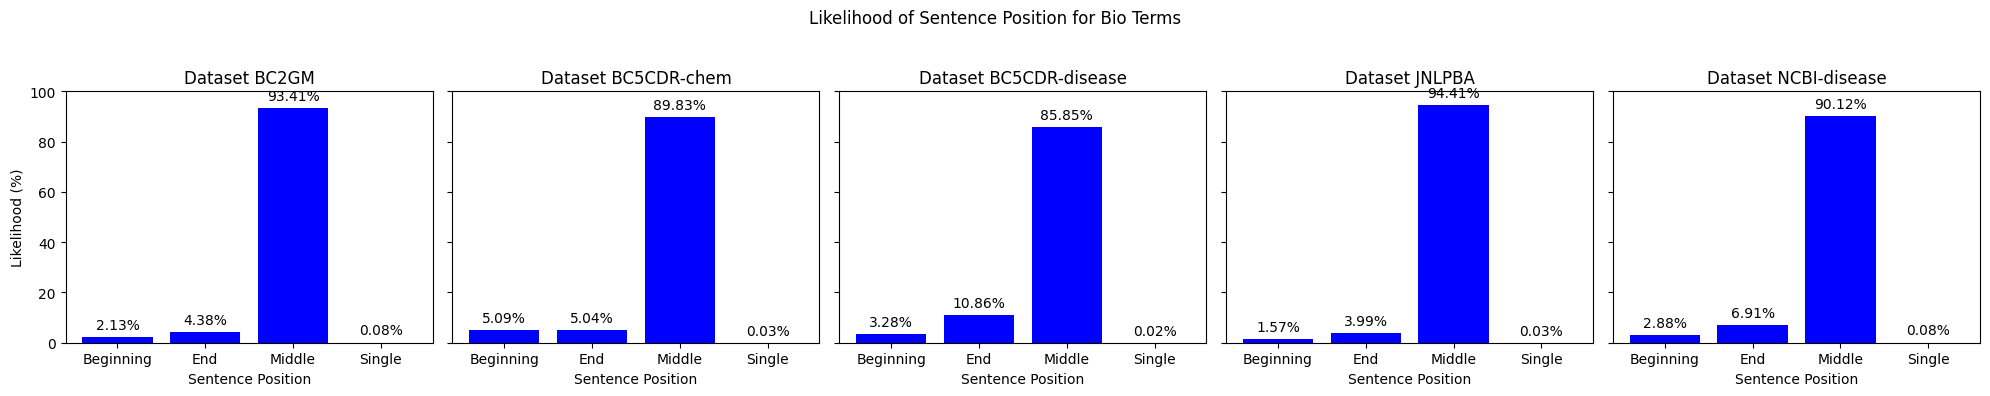

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)  # Adjust size as needed
fig.suptitle('Likelihood of Sentence Position for Bio Terms')

for i, df in enumerate(data):

    # position_counts = df['Position'].value_counts(normalize=True) * 100
    df = df[df['Position'].isin(['Beginning', 'Middle', 'End', 'Single'])]

    # Filter for biology terms
    bio_terms = df[df['Label'].isin(['B', 'I'])]

    # Count occurrences by position
    position_counts = bio_terms['Position'].value_counts()
    total_bio_terms = position_counts.sum()
    likelihoods = (position_counts / total_bio_terms * 100).sort_index()

    # Visualization
    bars = axes[i].bar(likelihoods.index, likelihoods.values, color='blue')
    axes[i].set_title(f'Dataset {dataset_names[i]}')
    axes[i].set_xlabel('Sentence Position')
    axes[i].set_ylim(0, 100)  # Consistent y-axis scale
    if i == 0:  # Only add ylabel to the first subplot to avoid clutter
        axes[i].set_ylabel('Likelihood (%)')

    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to fit the overall title
plt.show()

Change the sentence compartment definitions so that 1/3 of setnence is beginning, 1/3 is middle, 1/3 is end.

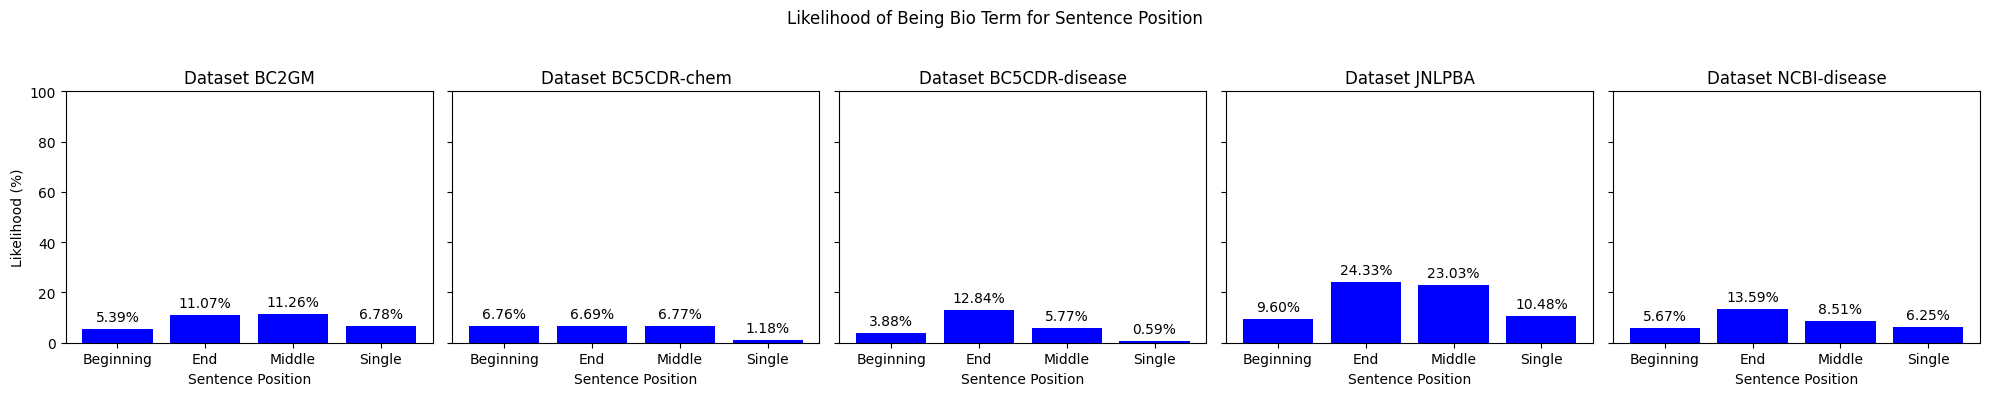

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)  # Adjust size as needed
fig.suptitle('Likelihood of Being Bio Term for Sentence Position')

for i, df in enumerate(data):
    df = df[df['Position'].isin(['Beginning', 'Middle', 'End', 'Single'])]
    bio_terms = df[df['Label'].isin(['B', 'I'])]
    position_counts = bio_terms['Position'].value_counts()
    total_position_counts = df['Position'].value_counts()
    likelihoods = (position_counts / total_position_counts * 100).sort_index()

    # Plotting the likelihoods
    bars = axes[i].bar(likelihoods.index, likelihoods.values, color='blue')
    axes[i].set_title(f'Dataset {dataset_names[i]}')
    axes[i].set_xlabel('Sentence Position')
    axes[i].set_ylim(0, 100)  # Consistent y-axis scale
    if i == 0:  # Only add ylabel to the first subplot to avoid clutter
        axes[i].set_ylabel('Likelihood (%)')

    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to fit the overall title
plt.show()

In [ ]:
for df in data:
    positions = []
    current_sentence = []
    total_tokens = len(df)
    for i, row in df.iterrows():
        if i < total_tokens // 3:
            positions.append('Beginning')
        elif i < total_tokens * 2 // 3:
            positions.append('Middle')
        else:
            positions.append('End')
    df['Corpus_Position'] = positions

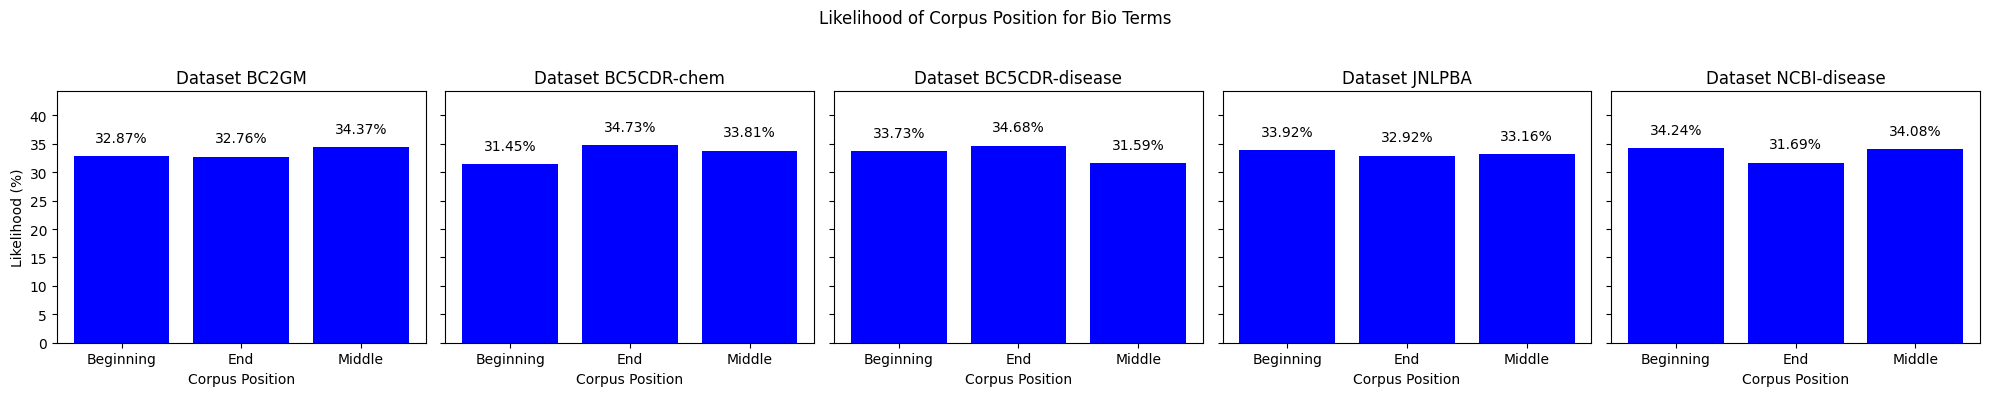

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)  # Adjust size as needed
fig.suptitle('Likelihood of Corpus Position for Bio Terms')

for i, df in enumerate(data):

    # position_counts = df['Position'].value_counts(normalize=True) * 100

    # Filter for biology terms
    bio_terms = df[df['Label'].isin(['B', 'I'])]

    # Count occurrences by position
    position_counts = bio_terms['Corpus_Position'].value_counts()
    total_bio_terms = position_counts.sum()
    likelihoods = (position_counts / total_bio_terms * 100).sort_index()

    # Visualization
    bars = axes[i].bar(likelihoods.index, likelihoods.values, color='blue')
    axes[i].set_title(f'Dataset {dataset_names[i]}')
    axes[i].set_xlabel('Corpus Position')
    axes[i].set_ylim(0, max(likelihoods.values) + 10)  # Consistent y-axis scale
    if i == 0:  # Only add ylabel to the first subplot to avoid clutter
        axes[i].set_ylabel('Likelihood (%)')

    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to fit the overall title
plt.show()

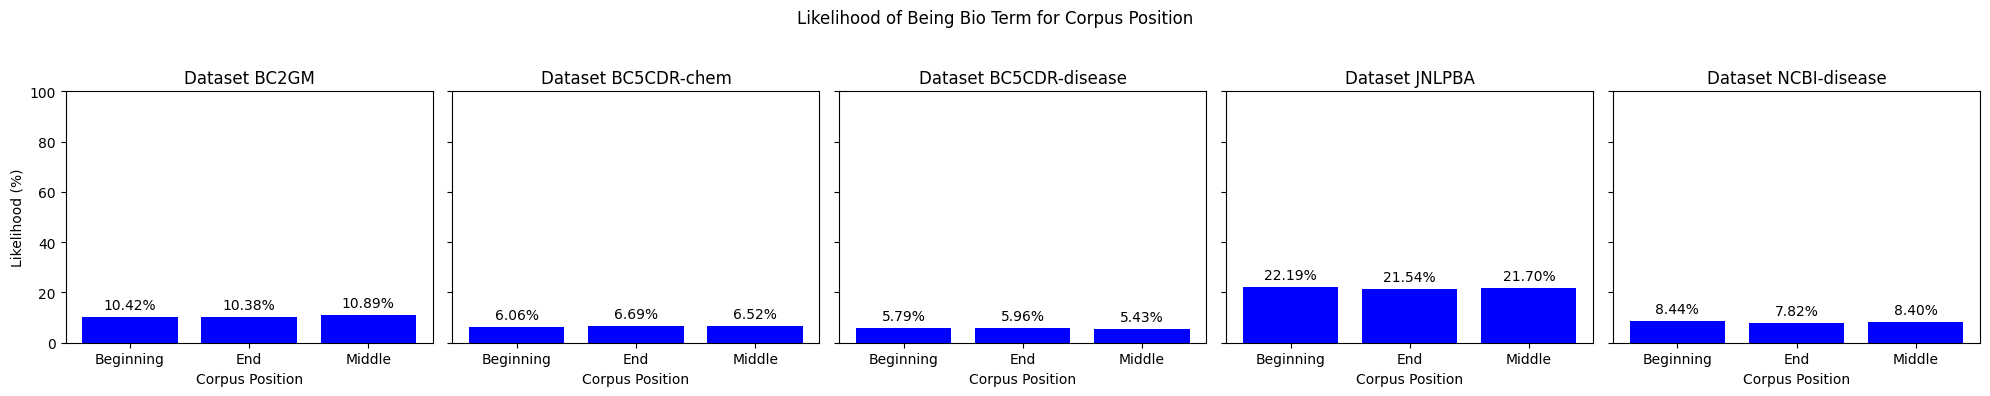

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)  # Adjust size as needed
fig.suptitle('Likelihood of Being Bio Term for Corpus Position')

for i, df in enumerate(data):
    bio_terms = df[df['Label'].isin(['B', 'I'])]
    position_counts = bio_terms['Corpus_Position'].value_counts()
    total_position_counts = df['Corpus_Position'].value_counts()
    likelihoods = (position_counts / total_position_counts * 100).sort_index()

    # Plotting the likelihoods
    bars = axes[i].bar(likelihoods.index, likelihoods.values, color='blue')
    axes[i].set_title(f'Dataset {dataset_names[i]}')
    axes[i].set_xlabel('Corpus Position')
    axes[i].set_ylim(0, 100)  # Consistent y-axis scale
    if i == 0:  # Only add ylabel to the first subplot to avoid clutter
        axes[i].set_ylabel('Likelihood (%)')

    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to fit the overall title
plt.show()